In [1]:
import os
import random
import numpy as np
import torch
import torch_geometric as pyg
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import negative_sampling
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv,GraphConv,global_mean_pool,global_add_pool
from torch_geometric.nn import global_mean_pool
from torch_geometric.loader import DataLoader
from ogb.linkproppred import PygLinkPropPredDataset,Evaluator #ogb-ddi (drug-drug interaction) dataset
from captum.attr import Saliency,IntegratedGradients
from collections import defaultdict

In [2]:
#--------------------ノード分類--------------------
dataset=Planetoid(root="data\\Planetoid", name="Cora", transform=NormalizeFeatures()) #Coraデータセットを取得
data=dataset[0] #グラフデータセットの最初のグラフ
print(dataset)
print(len(dataset)) #グラフの数
print("num_features:",dataset.num_features) #特徴量の数
print("num_classes:",dataset.num_classes) #クラス数
print(data) #yは各ノードのクラスラベルのベクトル　yは訓練、検証、テストの3つのマスク（train_mask,val_mask,test_mask）で構成されている
print("num_nodes:",data.num_nodes) #ノード数
print("num_edges:",data.num_edges) #エッジ数
print("has_roop:",data.has_self_loops()) #ループがあるか
print("is_directed:",data.is_directed()) #有向グラフかどうか

Cora()
1
num_features: 1433
num_classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
num_nodes: 2708
num_edges: 10556
has_roop: False
is_directed: False


In [3]:
#GCNモデルの構築
class GCN(torch.nn.Module):
    def __init__(self,hidden_channels):
        super().__init__()
        torch.manual_seed(1234567) #乱数シード
        self.conv1=GCNConv(dataset.num_features,hidden_channels) 
        self.conv2=GCNConv(hidden_channels,dataset.num_classes)
        
    def forward(self,x,edge_index):
        x=self.conv1(x,edge_index) #畳み込み1
        x=x.relu()
        x=F.dropout(x,p=0.5)
        x=self.conv2(x,edge_index) #畳み込み2
        return x
    
model=GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


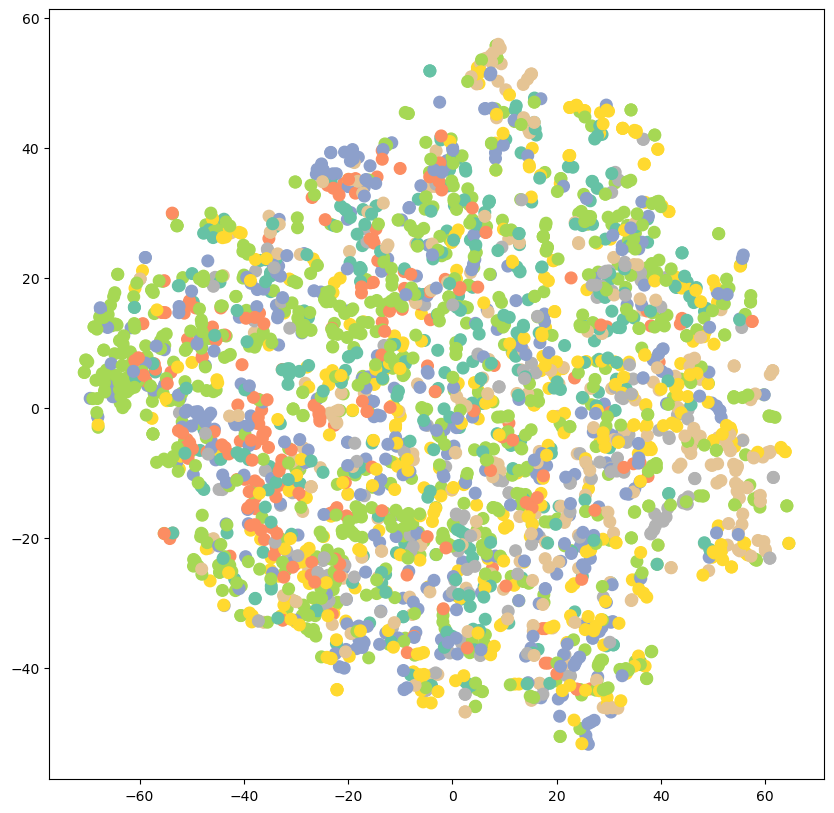

In [4]:
#学習前GCNでの埋め込みデータをTSNEで可視化
model.eval()

out=model(data.x,data.edge_index)
z=TSNE(n_components=2).fit_transform(out.detach().numpy()) #テンソルのコピーを作成して、numpy配列に変換してからTSNEで２次元変換
plt.figure(figsize=(10,10))
plt.scatter(z[:,0],z[:,1],s=70,c=data.y,cmap="Set2") #data.yは各ノードが属するクラス
plt.show()

In [5]:
#モデルの学習
optimizer=torch.optim.Adam(model.parameters(),lr=0.01,weight_decay=1e-4)
criterion=torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out=model(data.x,data.edge_index)
    loss=criterion(out[data.train_mask],data.y[data.train_mask]) #出力結果outとyの訓練マスク同士での誤差を算出
    loss.backward()
    optimizer.step()
    return loss

for epoch in range(1,101):
    loss=train()
    print("Epoch:",epoch," Loss:",loss)

Epoch: 1  Loss: tensor(1.9463, grad_fn=<NllLossBackward0>)
Epoch: 2  Loss: tensor(1.9404, grad_fn=<NllLossBackward0>)
Epoch: 3  Loss: tensor(1.9340, grad_fn=<NllLossBackward0>)
Epoch: 4  Loss: tensor(1.9231, grad_fn=<NllLossBackward0>)
Epoch: 5  Loss: tensor(1.9141, grad_fn=<NllLossBackward0>)
Epoch: 6  Loss: tensor(1.9037, grad_fn=<NllLossBackward0>)
Epoch: 7  Loss: tensor(1.8934, grad_fn=<NllLossBackward0>)
Epoch: 8  Loss: tensor(1.8806, grad_fn=<NllLossBackward0>)
Epoch: 9  Loss: tensor(1.8683, grad_fn=<NllLossBackward0>)
Epoch: 10  Loss: tensor(1.8564, grad_fn=<NllLossBackward0>)
Epoch: 11  Loss: tensor(1.8425, grad_fn=<NllLossBackward0>)
Epoch: 12  Loss: tensor(1.8225, grad_fn=<NllLossBackward0>)
Epoch: 13  Loss: tensor(1.8150, grad_fn=<NllLossBackward0>)
Epoch: 14  Loss: tensor(1.7949, grad_fn=<NllLossBackward0>)
Epoch: 15  Loss: tensor(1.7824, grad_fn=<NllLossBackward0>)
Epoch: 16  Loss: tensor(1.7658, grad_fn=<NllLossBackward0>)
Epoch: 17  Loss: tensor(1.7429, grad_fn=<NllLossB

In [6]:
#モデルのテスト
def test():
    model.eval()
    out=model(data.x,data.edge_index)
    pred=out.argmax(dim=1) #行ごとの最大値の列を返す
    test_correct=pred[data.test_mask]==data.y[data.test_mask] #出力結果outとyのテストマスク同士を比較
    test_acc=int(test_correct.sum())/int(data.test_mask.sum()) #正答率
    return test_acc

test_acc=test()
print("Test_Accuracy:",test_acc)

Test_Accuracy: 0.723


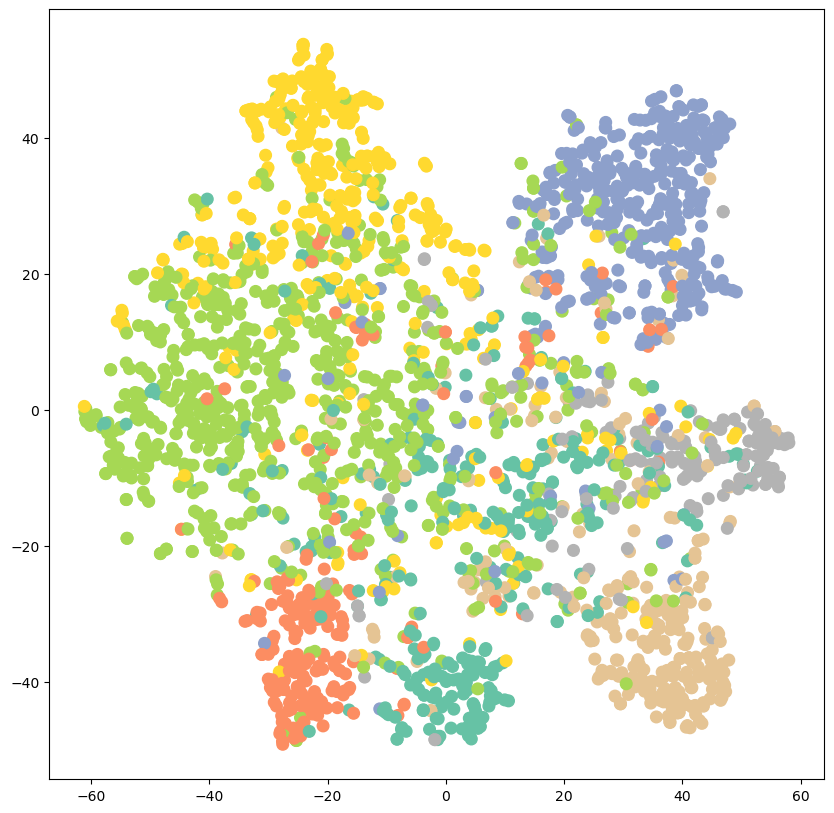

In [7]:
#学習済みGCNでの埋め込みデータをTSNEで可視化
model.eval()
out=model(data.x,data.edge_index)
z=TSNE(n_components=2).fit_transform(out.detach().numpy())
plt.figure(figsize=(10,10))
plt.scatter(z[:,0],z[:,1],s=70,c=data.y,cmap="Set2") 
plt.show()

In [8]:
#--------------------グラフ分類--------------------
dataset=TUDataset(root="data\\TuDataset", name="MUTAG") #MUTAGデータセットを取得
data=dataset[0] #グラフデータセットの最初のグラフ
print(dataset)
print(len(dataset)) #グラフの数
print("num_features:",dataset.num_features) #特徴量の数
print("num_classes:",dataset.num_classes) #クラス数
print(data) #yはグラフの属するクラス
print("num_nodes:",data.num_nodes) #ノード数
print("num_edges:",data.num_edges) #エッジ数
print("has_roop:",data.has_self_loops()) #ループがあるか
print("is_directed:",data.is_directed()) #有向グラフかどうか

MUTAG(188)
188
num_features: 7
num_classes: 2
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
num_nodes: 17
num_edges: 38
has_roop: False
is_directed: False


In [9]:
#datasetを訓練用とテスト用に分ける
torch.manual_seed(12345)
dataset=dataset.shuffle()
train_dataset=dataset[:150]
test_dataset=dataset[150:]
print(len(train_dataset))
print(len(test_dataset))

150
38


In [10]:
#ミニバッチを作成
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False)

In [11]:
#GCNモデルの構築
class GCN(torch.nn.Module):
    def __init__(self,hidden_channels):
        super().__init__()
        torch.manual_seed(12345) #乱数シード
        self.conv1=GCNConv(dataset.num_node_features,hidden_channels) 
        self.conv2=GCNConv(hidden_channels,hidden_channels)
        self.conv3=GCNConv(hidden_channels,hidden_channels)
        self.lin=Linear(hidden_channels,dataset.num_classes)
        
    def forward(self,x,edge_index,batch):
        x=self.conv1(x,edge_index)
        x=x.relu()
        x=self.conv2(x,edge_index)
        x=x.relu()
        x=self.conv3(x,edge_index)
        x=global_mean_pool(x,batch) #グローバル平均プーリングで各バッチの平均を算出
        x=F.dropout(x,p=0.5)
        x=self.lin(x) #全結合で２値を算出
        return x
        
model=GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [12]:
#モデルの学習とテスト
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)
criterion=torch.nn.CrossEntropyLoss()

def train():
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        out=model(data.x,data.edge_index,data.batch)
        loss=criterion(out,data.y)
        loss.backward()
        optimizer.step()

def test(loader):
    model.eval()
    correct=0
    for data in loader:
        out=model(data.x,data.edge_index,data.batch)
        pred=out.argmax(dim=1)
        correct+=int((pred==data.y).sum())
    return round(correct/len(loader.dataset),3) #小数点第3位

for epoch in range(1,201):
    train()
    train_acc=test(train_loader)
    test_acc=test(test_loader)
    print("Epoch:",epoch,"Train Accuracy:",train_acc,"Test Accuracy:",test_acc)

Epoch: 1 Train Accuracy: 0.647 Test Accuracy: 0.737
Epoch: 2 Train Accuracy: 0.647 Test Accuracy: 0.737
Epoch: 3 Train Accuracy: 0.64 Test Accuracy: 0.711
Epoch: 4 Train Accuracy: 0.647 Test Accuracy: 0.737
Epoch: 5 Train Accuracy: 0.647 Test Accuracy: 0.737
Epoch: 6 Train Accuracy: 0.647 Test Accuracy: 0.737
Epoch: 7 Train Accuracy: 0.647 Test Accuracy: 0.737
Epoch: 8 Train Accuracy: 0.647 Test Accuracy: 0.737
Epoch: 9 Train Accuracy: 0.733 Test Accuracy: 0.816
Epoch: 10 Train Accuracy: 0.707 Test Accuracy: 0.789
Epoch: 11 Train Accuracy: 0.707 Test Accuracy: 0.763
Epoch: 12 Train Accuracy: 0.727 Test Accuracy: 0.789
Epoch: 13 Train Accuracy: 0.693 Test Accuracy: 0.789
Epoch: 14 Train Accuracy: 0.68 Test Accuracy: 0.789
Epoch: 15 Train Accuracy: 0.707 Test Accuracy: 0.789
Epoch: 16 Train Accuracy: 0.74 Test Accuracy: 0.711
Epoch: 17 Train Accuracy: 0.727 Test Accuracy: 0.763
Epoch: 18 Train Accuracy: 0.707 Test Accuracy: 0.816
Epoch: 19 Train Accuracy: 0.727 Test Accuracy: 0.789
Epoch

In [13]:
#モデルの出力
model.eval()
for data in test_loader:
    classification=model(data.x,data.edge_index,data.batch)
    print(classification) #各グラフの２値分類結果を出力

tensor([[-1.0791,  0.9058],
        [-0.8040,  0.8063],
        [-0.8372,  0.9692],
        [-0.4542,  0.3687],
        [-0.6973,  0.4606],
        [ 0.8343, -0.9335],
        [ 0.6584, -1.0166],
        [-0.4137,  0.4588],
        [-0.0862,  0.1057],
        [-1.4517,  1.5107],
        [-1.1261,  0.9651],
        [-0.8335,  0.6942],
        [ 0.0581, -0.1609],
        [-0.2090,  0.0811],
        [ 0.0797, -0.2042],
        [-1.3734,  1.4494],
        [ 0.0279, -0.1537],
        [-1.3036,  1.1117],
        [ 0.0749, -0.1740],
        [ 0.1957, -0.1671],
        [-0.3641,  0.3758],
        [-0.3578,  0.3631],
        [ 0.8031, -0.7410],
        [-1.0845,  0.7982],
        [-0.0645,  0.0757],
        [ 0.2166, -0.3119],
        [-0.8141,  0.7643],
        [-0.0540, -0.0669],
        [-1.0249,  1.0309],
        [-0.0249, -0.0918],
        [-1.4848,  1.5157],
        [-1.3061,  1.3401],
        [-0.9929,  1.1203],
        [-1.0088,  1.0157],
        [-1.2306,  1.3509],
        [-0.3503,  0

In [14]:
#--------------------モデルの予測における各入力特徴量の説明--------------------
dataset=TUDataset(root=".", name="Mutagenicity").shuffle() 
test_dataset=dataset[:len(dataset)//10] #//は割った商の整数値
train_dataset=dataset[len(dataset)//10:]
test_loader=DataLoader(test_dataset,batch_size=128)
train_loader=DataLoader(train_dataset,batch_size=128)

In [15]:
#ネットワークの可視化
def to_molecule(data): #ノードに属性を付与したグラフを取得
    Atom_map=['C', 'O', 'Cl', 'H', 'N', 'F', 'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
    g=to_networkx(data,node_attrs=["x"]) #入力データをグラフに変換　各ノードがどの原子を表すかを示すインデックスのリストであるxを作成
    for i,data in g.nodes(data=True):
        data["name"]=Atom_map[data["x"].index(1.0)] #値１.0のindex（そのノードが表す原子）を取得して格納
        del data["x"] #dataのx属性を削除
    return g

def draw_molecule(g,edge_mask=None,draw_edge_labels=False): #グラフを描画
    g=g.copy().to_undirected()
    node_labels={}
    for i,data in g.nodes(data=True): #data=Trueでノードと属性情報の辞書を返す
        node_labels[i]=data["name"] #各ノードのname属性をラベルとして取得
    pos=nx.planar_layout(g) #エッジが交差しないように設定
    pos=nx.spring_layout(g,pos=pos)
    if edge_mask is None: #エッジマスクが無い場合
        edge_color="black"
        widths=None
    else: #エッジマスクがある場合
        edge_color=[edge_mask[u,v] for u,v in g.edges()] #エッジを取得
        widths=[x*10 for x in edge_color] #幅を10倍に変換
    nx.draw(g,pos=pos,labels=node_labels,width=widths, #widthはエッジの濃さ
            edge_color=edge_color,edge_cmap=plt.cm.Blues,node_color="azure") #ノードはazure色 エッジの値に応じて色を設定
    
    if draw_edge_labels and edge_mask is not None:
        edge_labels={k:v for k,v in edge_mask.items()} #エッジマスクからエッジラベルを取得
        nx.draw_networkx_edge_labels(g,pos,edge_labels=edge_labels,font_color="red") 
        
    plt.show()

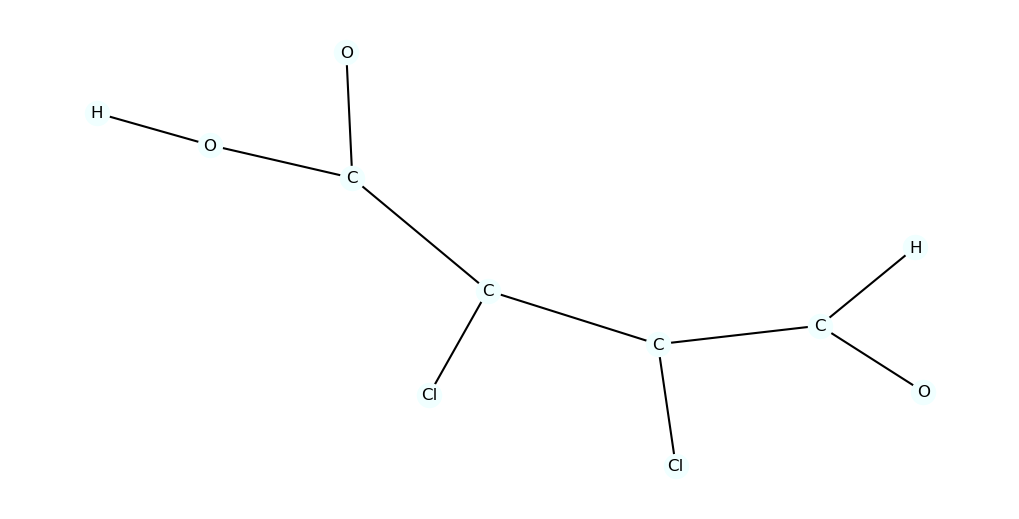

In [16]:
#可視化を実行
data=random.choice([t for t in train_dataset]) #train_datasetからランダムにネットワークデータを取得
mol=to_molecule(data) #ネットワークグラフを作成
plt.figure(figsize=(10,5))
draw_molecule(mol)

In [17]:
#関数で用いた内部処理の確認
data=random.choice([t for t in train_dataset])
g=to_networkx(data,node_attrs=["x"])
nx.get_node_attributes(g,"x") #ノードの属性であるxを表示

{0: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 1: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 2: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 3: [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 4: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 5: [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 6: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 7: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 8: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 9: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 10: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 11: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 12: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 13: [0.0

In [18]:
#モデルの構築
class Net(torch.nn.Module): #グラフ分類モデル
    def __init__(self,dim):
        super().__init__()
        num_features=dataset.num_features
        self.dim=dim
        
        self.conv1=GraphConv(num_features,dim)
        self.conv2=GraphConv(dim,dim)
        self.conv3=GraphConv(dim,dim)
        self.conv4=GraphConv(dim,dim)
        self.conv5=GraphConv(dim,dim)
        self.lin1=Linear(dim,dim)
        self.lin2=Linear(dim,dataset.num_classes)
        
    def forward(self,x,edge_index,batch,edge_weight=None):
        x=self.conv1(x,edge_index,edge_weight).relu()
        x=self.conv2(x,edge_index,edge_weight).relu()
        x=self.conv3(x,edge_index,edge_weight).relu()
        x=self.conv4(x,edge_index,edge_weight).relu()
        x=self.conv5(x,edge_index,edge_weight).relu()
        x=global_add_pool(x,batch) #全てのノード特徴量を合計
        x=self.lin1(x).relu()
        x=F.dropout(x,p=0.5)
        x=self.lin2(x)
        return F.log_softmax(x,dim=-1)

In [19]:
#学習とテストを定義
def train(epoch):
    model.train()
    
    if epoch==51: #51回目になったら
        for param_group in optimizer.param_groups: #各層のパラメータを取得
            param_group["lr"]=0.5*param_group["lr"] #学習率のスケーリング　学習率を半分にする
            
    loss_all=0
    for data in train_loader:
        data=data.to(device)
        optimizer.zero_grad()
        output=model(data.x,data.edge_index,data.batch)
        loss=F.nll_loss(output,data.y)
        loss.backward()
        loss_all+=loss.item()*data.num_graphs #各バッチの損失を合計して加算
        optimizer.step()
    return loss_all/len(train_dataset)

def test(loader):
    model.eval()
    correct=0
    for data in loader:
        data=data.to(device)
        output=model(data.x,data.edge_index,data.batch)
        pred=output.max(dim=1)[1] #最大値のindexを取得
        correct+=pred.eq(data.y).sum().item() #正しい予測の合計を加算
    return correct/len(loader.dataset)

In [20]:
#モデルの学習
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=Net(dim=32).to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

for epoch in range(1,101):
    loss=train(epoch)
    train_acc=test(train_loader)
    test_acc=test(test_loader)
    print("Epoch:",epoch, f"Loss: {loss:.3f} Train: {train_acc:.3f} Test: {test_acc:.3f}")

Epoch: 1 Loss: 0.926 Train: 0.615 Test: 0.575
Epoch: 2 Loss: 0.636 Train: 0.674 Test: 0.640
Epoch: 3 Loss: 0.607 Train: 0.679 Test: 0.647
Epoch: 4 Loss: 0.605 Train: 0.697 Test: 0.661
Epoch: 5 Loss: 0.577 Train: 0.717 Test: 0.674
Epoch: 6 Loss: 0.571 Train: 0.723 Test: 0.709
Epoch: 7 Loss: 0.554 Train: 0.739 Test: 0.714
Epoch: 8 Loss: 0.558 Train: 0.736 Test: 0.709
Epoch: 9 Loss: 0.539 Train: 0.738 Test: 0.723
Epoch: 10 Loss: 0.528 Train: 0.752 Test: 0.704
Epoch: 11 Loss: 0.526 Train: 0.755 Test: 0.734
Epoch: 12 Loss: 0.522 Train: 0.757 Test: 0.741
Epoch: 13 Loss: 0.524 Train: 0.769 Test: 0.748
Epoch: 14 Loss: 0.510 Train: 0.761 Test: 0.718
Epoch: 15 Loss: 0.497 Train: 0.774 Test: 0.748
Epoch: 16 Loss: 0.495 Train: 0.761 Test: 0.741
Epoch: 17 Loss: 0.484 Train: 0.766 Test: 0.755
Epoch: 18 Loss: 0.475 Train: 0.783 Test: 0.758
Epoch: 19 Loss: 0.475 Train: 0.788 Test: 0.760
Epoch: 20 Loss: 0.470 Train: 0.801 Test: 0.785
Epoch: 21 Loss: 0.462 Train: 0.802 Test: 0.776
Epoch: 22 Loss: 0.460 

In [21]:
def model_forward(edge_mask,data): #edge_maskありでモデルを実行する
    batch=torch.zeros(data.x.shape[0],dtype=int).to(device) #dataの形状に基づいたバッチを0で初期化
    out=model(data.x,data.edge_index,batch,edge_mask)
    return out

def explain(method,data,target=0): #指定した方法でedge_mask（エッジの重要度を表すマスク）を生成する
    input_mask=torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device) #入力マスクを初期化
    if method=="ig":
        ig=IntegratedGradients(model_forward)
        mask=ig.attribute(input_mask,target=target,additional_forward_args=(data,),internal_batch_size=data.edge_index.shape[1]) #入力マスクに対する属性
        
    elif method=="saliency":
        saliency=Saliency(model_forward)
        mask=saliency.attribute(input_mask,target=target,additional_forward_args=(data,))
    
    else:
        raise Exception('Unknown explanation method')
        
    edge_mask=np.abs(mask.cpu().detach().numpy()) #マスクの絶対値をとりnumpy配列に変換
    if edge_mask.max()>0:
        edge_mask=edge_mask/edge_mask.max() #エッジマスクを最大値で正規化
    return edge_mask

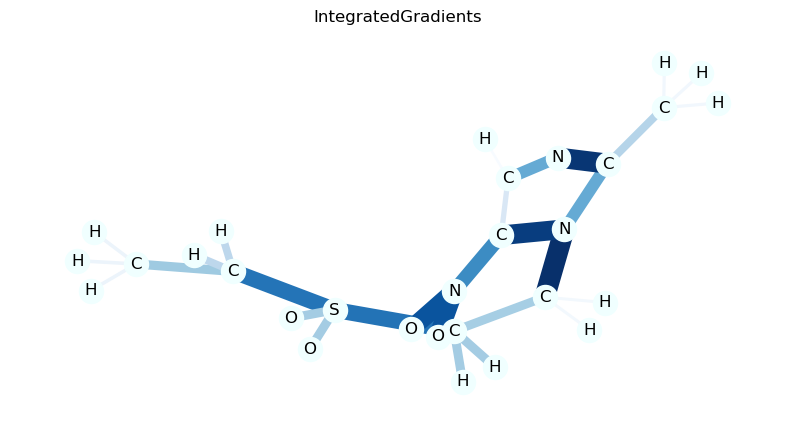

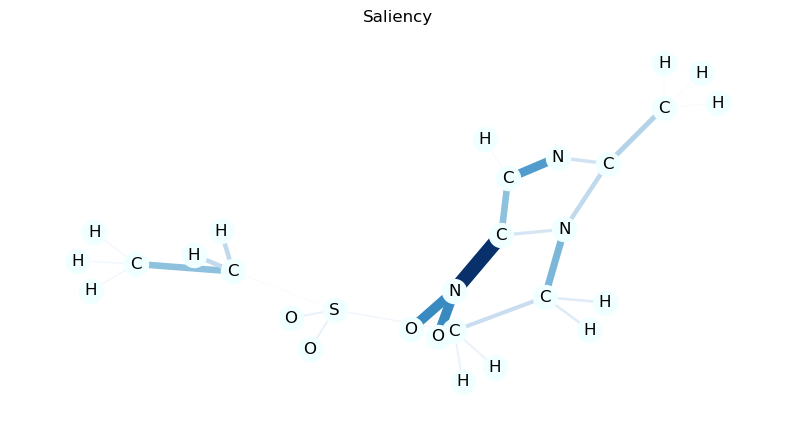

In [22]:
#説明の生成と表示
def aggregate_edge_directions(edge_mask,data): #エッジの方向を集約する
    edge_mask_dict=defaultdict(float) #エッジマスクの辞書を初期化
    for val,u,v in list(zip(edge_mask,*data.edge_index)): #エッジマスクとエッジindexをループ　valはエッジの重要度　uとvはエッジのノード
        u,v=u.item(),v.item() #ノードのindexを取得
        if u>v: #ノードのindexが大きい方をu、小さい方をv
            u,v=v,u
        edge_mask_dict[(u,v)]+=val #辞書にエッジの重要度を追加
    return edge_mask_dict

data=random.choice([t for t in test_dataset if not t.y.item()])
mol=to_molecule(data)

for title,method in [("IntegratedGradients","ig"),("Saliency","saliency")]:
    edge_mask=explain(method,data,target=0) #説明を生成
    edge_mask_dict=aggregate_edge_directions(edge_mask,data) #エッジの方向を集約
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol,edge_mask_dict)